# Sailing Challenge: Understanding the Environment

Welcome to the Sailing Challenge! In this walkthrough notebook, we'll explore the sailing environment in depth to build your understanding of the physics, dynamics, and challenges you'll face when developing your sailing agent.

This notebook is designed to be pedagogical and comprehensive, helping you understand:

1. **Environment Basics**: The structure of the sailing world, goals, and observations
2. **Sailing Physics**: How real-world sailing principles are implemented
3. **Wind Patterns**: How wind varies and affects navigation
4. **Control Mechanics**: How actions translate to boat movement
5. **Observation and State Space**: What information your agent receives
6. **Reward Structure**: How success is measured

By the end of this notebook, you'll have the knowledge needed to start developing your own sailing agent.

## 1. Setup and Imports

First, let's import all the necessary modules. Our environment uses standard scientific Python libraries along with custom modules for the sailing environment.

In [2]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# Add the src directory to the path
sys.path.append(os.path.abspath('../src'))
sys.path.append(os.path.abspath('..'))

# Import the environment and evaluation modules
from env_sailing import SailingEnv
from evaluation import evaluate_agent, visualize_trajectory
from sailing_physics import (
    generate_velocity_polar_plot, 
    generate_efficiency_curve,
    show_tacking_maneuver  # Add this import
)

# Import scenarios
from initial_windfields import get_initial_windfield, INITIAL_WINDFIELDS

## 2. Environment Overview

The sailing environment simulates a boat navigating from a starting point to a goal while being affected by wind. This is a challenging control problem because:

1. The boat can't move directly against the wind (upwind sailing requires tacking)
2. Wind conditions change over time and vary across the space
3. Boat physics include momentum and sailing efficiency based on wind angle
4. Optimal routes are rarely straight lines to the goal

Let's start by creating a basic environment and visualizing it:

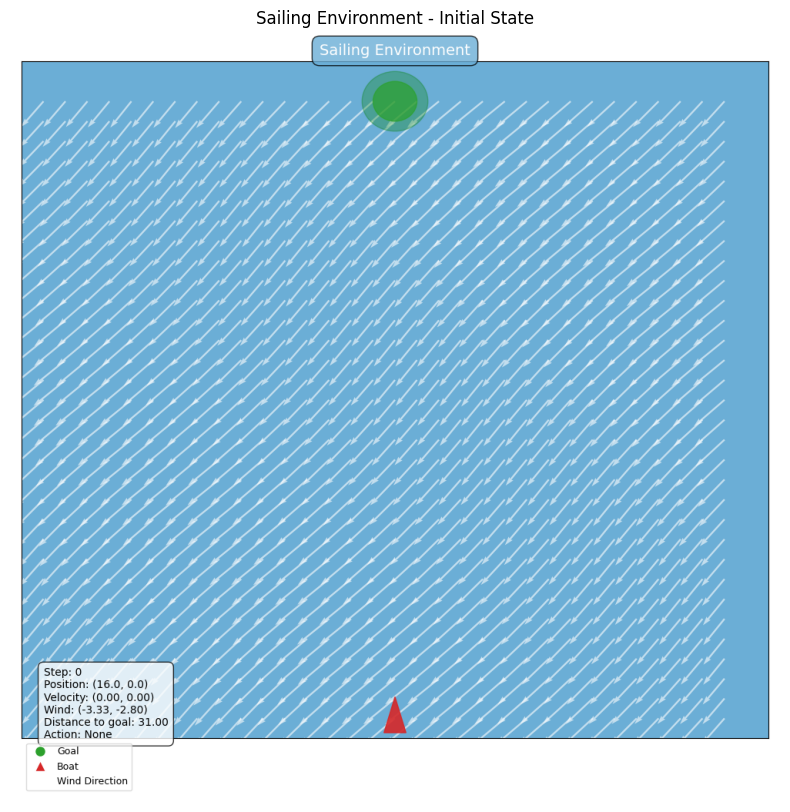

Environment Information:
Grid Size: (32, 32)
Starting Position: [16  0]
Goal Position: [16 31]
Initial Wind at Boat: [-3.32917761 -2.80499559]


In [3]:
# Create a basic sailing environment
env = SailingEnv(
    grid_size=(32, 32),  # 32x32 grid world
    wind_grid_density=25,  # How many wind arrows to display
    wind_arrow_scale=80,  # Scale factor for arrow visualization
    render_mode="rgb_array"  # Generate images for visualization
)

# Reset the environment to initialize
observation, info = env.reset(seed=42)  # Fixed seed for reproducibility

# Render the environment
plt.figure(figsize=(10, 10))
plt.imshow(env.render())
plt.axis('off')
plt.title('Sailing Environment - Initial State')
plt.show()

# Describe the environment
print("Environment Information:")
print(f"Grid Size: {env.grid_size}")
print(f"Starting Position: {info['position']}")
print(f"Goal Position: {env.goal_position}")
print(f"Initial Wind at Boat: {info['wind']}")

### Understanding the Visualization

In the visualization above:

- **Boat**: The triangular shape represents your sailing boat. The pointed end indicates the direction.
- **Wind Arrows**: The blue arrows show wind direction and strength at different points in the grid.
- **Goal**: The red circle at the top center is your destination.
- **Grid**: The background represents the sailing area (think of it as a lake or sea).

The challenge is to navigate the boat from the starting position (bottom) to the goal (top) by choosing appropriate sailing directions that account for the wind.

### Initial Windfields

The wind field you can see in the previous rendering is generated based on parameters defined during environment creation. In the real challenge, you'll encounter several different initial wind fields:

1. **Training Initial Windfields**: These are provided for you to develop and test your agent:
   - **Training Initial Windfield 1**: Features north-northwest wind patterns
   - **Training Initial Windfield 2**: Features north-northeast wind patterns
   - **Training Initial Windfield 3**: Features pure north wind patterns

2. **Test Initial Windfield**: A hidden initial windfield used for final evaluation (not accessible during development)

Each initial windfield has unique characteristics in terms of:
- Base wind direction and strength
- Spatial wind patterns across the grid
- Pattern scales and strength variations

It's important to understand that while the initial windfields differ in their starting conditions, they all evolve over time according to the same underlying dynamics. This means that regardless of which initial windfield you're dealing with, the wind will follow similar evolution rules (perturbation amplitude, rotation rates, etc.) as time progresses within an episode. Think of the initial windfields as different starting points, but with consistent physics governing how they change.

The predefined initial windfields are available in the `initial_windfields` module and can be loaded using the `get_initial_windfield()` function. We'll explore these different initial windfields later in this notebook to understand how your agent will need to adapt to different wind conditions.

Let's continue exploring the environment basics before diving into different initial windfields.

## 3. Sailing Physics: How Wind Affects Movement

Sailing involves a fascinating interplay of physics. Unlike motorboats that can go in any direction, sailboats are constrained by their relation to the wind. Let's explore how sailing efficiency varies depending on the angle to the wind:

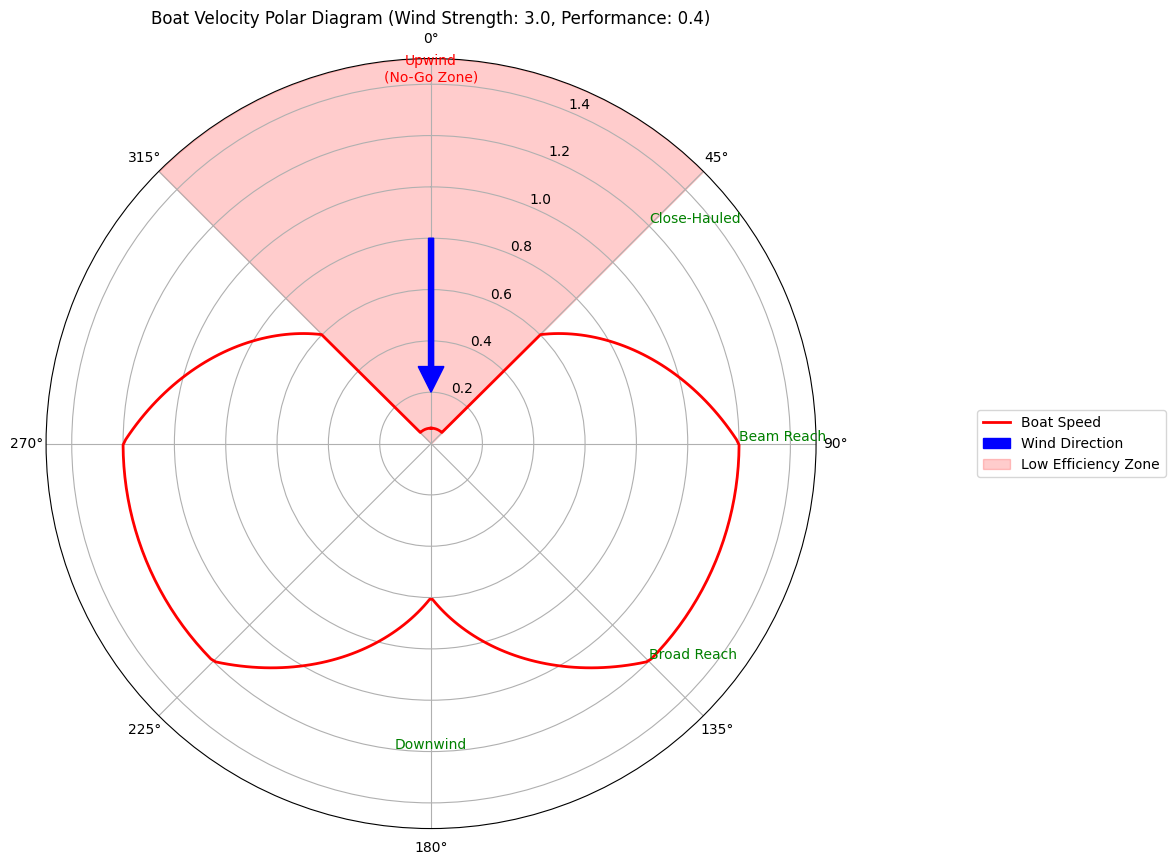

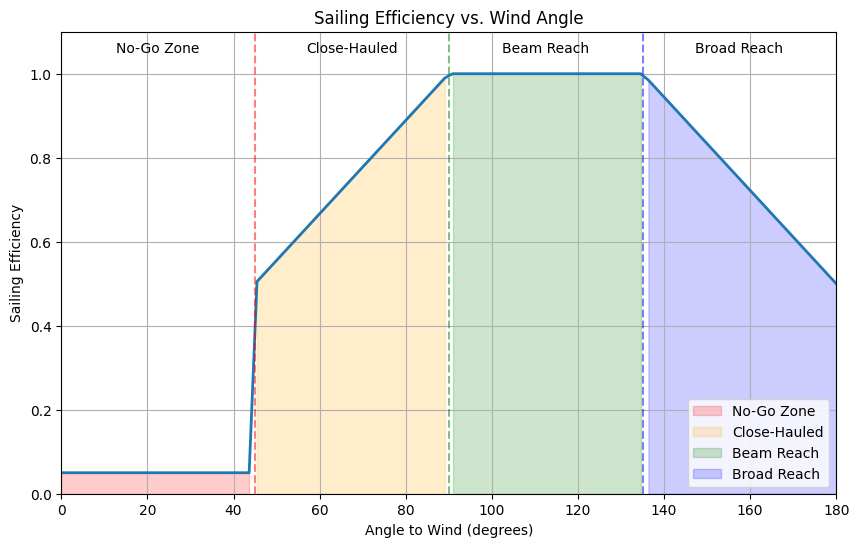

Key Sailing Concepts:
1. No-Go Zone: You cannot sail directly into the wind (within ~45° of upwind)
2. Close-hauled: Sailing at ~45° to the wind - relatively efficient but not optimal
3. Beam Reach: Sailing perpendicular to the wind - typically the fastest point of sail
4. Broad Reach: Wind coming from behind at an angle - also very efficient
5. Running: Wind directly behind - surprisingly not the fastest due to aerodynamics


In [4]:
# Create a polar plot showing sailing efficiency by angle
polar_fig = generate_velocity_polar_plot(wind_strength=3.0, boat_performance=0.4)
plt.show()

# Create an efficiency curve
eff_fig = generate_efficiency_curve()
plt.show()

print("Key Sailing Concepts:")
print("1. No-Go Zone: You cannot sail directly into the wind (within ~45° of upwind)")
print("2. Close-hauled: Sailing at ~45° to the wind - relatively efficient but not optimal")
print("3. Beam Reach: Sailing perpendicular to the wind - typically the fastest point of sail")
print("4. Broad Reach: Wind coming from behind at an angle - also very efficient")
print("5. Running: Wind directly behind - surprisingly not the fastest due to aerodynamics")

### Tacking: The Key to Upwind Sailing

Since you cannot sail directly into the wind, the key strategy for reaching a destination that's upwind is called "tacking" - a zigzag pattern that involves sailing at angles to the wind.

Let's visualize a tacking pattern:

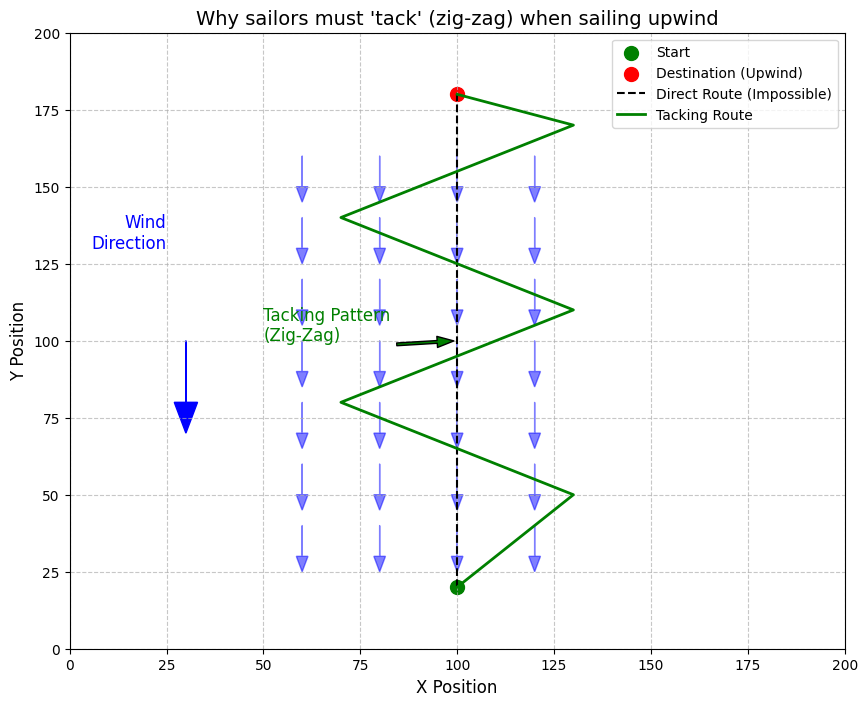

Tacking Strategy:
- When the goal is upwind (against the wind), you cannot sail directly toward it
- Instead, zigzag at approximately 45° angles to the wind
- This creates a longer path but allows you to reach upwind destinations
- Skilled sailors minimize the number of tacks while maximizing upwind progress


In [5]:
# Display a tacking visualization
tack_fig = show_tacking_maneuver()
plt.show()

print("Tacking Strategy:")
print("- When the goal is upwind (against the wind), you cannot sail directly toward it")
print("- Instead, zigzag at approximately 45° angles to the wind")
print("- This creates a longer path but allows you to reach upwind destinations")
print("- Skilled sailors minimize the number of tacks while maximizing upwind progress")

## 4. Actions and Control Mechanics

In the sailing environment, your agent needs to choose from a discrete set of actions to navigate the boat. Let's understand the action space and how it affects the boat's movement.

### Action Space

There are 9 possible actions your agent can take:
- Actions 0-7: Move in one of 8 directions (like compass points)
- Action 8: Stay in place

These actions represent the direction you want the boat to move, but the actual movement will be influenced by:
- Wind direction and strength
- Sailing efficiency at that angle to the wind
- Current velocity (momentum)
- Physical constraints of sailing

Let's see how these actions correspond to directions:

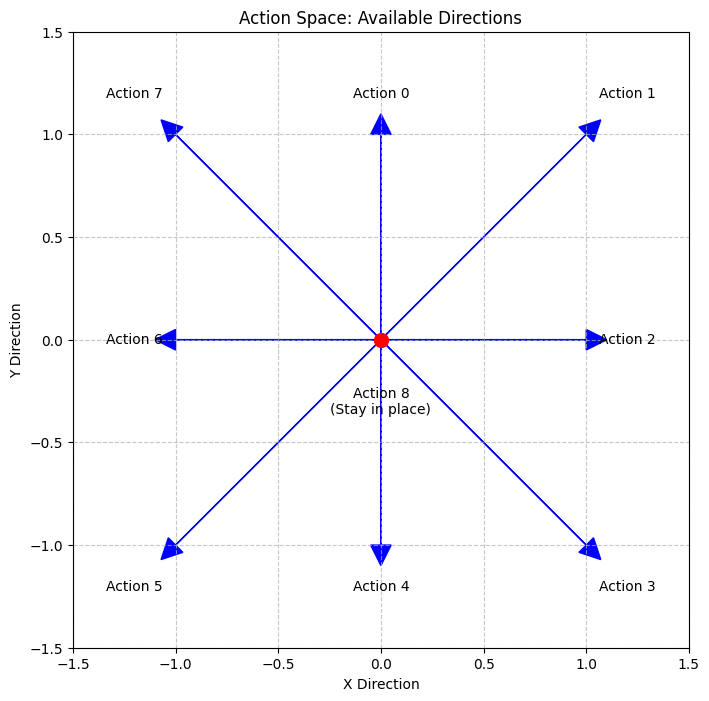

Important Note: The actual movement resulting from each action will depend on wind conditions!
- Trying to move directly upwind (against the wind) will result in minimal progress
- Moving perpendicular to the wind (beam reach) will be most efficient
- Your agent needs to learn which actions are effective in different wind conditions


In [6]:
# Define the action space
actions = [
    (0, 1),    # 0: North
    (1, 1),    # 1: Northeast
    (1, 0),    # 2: East
    (1, -1),   # 3: Southeast
    (0, -1),   # 4: South
    (-1, -1),  # 5: Southwest
    (-1, 0),   # 6: West
    (-1, 1),   # 7: Northwest
    (0, 0)     # 8: Stay in place
]

# Create a visual representation of the action space
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)

# Draw arrows for each direction
for i, (dx, dy) in enumerate(actions[:8]):  # Skip the "stay in place" action
    ax.arrow(0, 0, dx, dy, head_width=0.1, head_length=0.1, fc='blue', ec='blue')
    ax.text(dx*1.2, dy*1.2, f"Action {i}", ha='center', va='center')

# Mark the center for "stay in place"
ax.plot(0, 0, 'ro', markersize=10)
ax.text(0, -0.3, "Action 8\n(Stay in place)", ha='center', va='center')

# Add grid, title and labels
ax.grid(True, linestyle='--', alpha=0.7)
ax.set_title('Action Space: Available Directions')
ax.set_xlabel('X Direction')
ax.set_ylabel('Y Direction')
ax.set_aspect('equal')
plt.show()

print("Important Note: The actual movement resulting from each action will depend on wind conditions!")
print("- Trying to move directly upwind (against the wind) will result in minimal progress")
print("- Moving perpendicular to the wind (beam reach) will be most efficient")
print("- Your agent needs to learn which actions are effective in different wind conditions")

## 5. Observation and State Space

Your agent will make decisions based on observations from the environment. Let's understand what information is available to your agent at each step.

### Observation Structure

The observation is now an extended vector containing:
- `x, y`: Current position (indices 0, 1)
- `vx, vy`: Current velocity (indices 2, 3)
- `wx, wy`: Current wind vector at the boat's position (indices 4, 5)
- **Full Wind Field**: The complete wind field flattened into a 1D array (indices 6 onward)

The full wind field provides your agent with "weather information" - knowledge about wind conditions across the entire environment. This is a powerful feature that allows your agent to plan routes strategically, similar to how real sailors use weather forecasts.

Let's examine a sample observation:

Observation shape: (2054,)

Observation breakdown:
Position (x, y): (16.0, 0.0)
Velocity (vx, vy): (0.000, 0.000)
Wind at position (wx, wy): (-3.329, -2.805)

Wind field information:
Grid size: (32, 32)
Flattened wind field size: 2048
Wind field in observation: indices 6 to 2053

Sample of wind field data (first 10 points):
Grid point 0: Wind (wx, wy) = (-2.344, -2.733)
Grid point 1: Wind (wx, wy) = (-2.308, -2.770)
Grid point 2: Wind (wx, wy) = (-2.312, -2.765)
Grid point 3: Wind (wx, wy) = (-2.260, -2.799)
Grid point 4: Wind (wx, wy) = (-2.283, -2.811)
Grid point 5: Wind (wx, wy) = (-2.314, -2.825)
Grid point 6: Wind (wx, wy) = (-2.399, -2.858)
Grid point 7: Wind (wx, wy) = (-2.454, -2.858)
Grid point 8: Wind (wx, wy) = (-2.546, -2.898)
Grid point 9: Wind (wx, wy) = (-2.620, -2.896)


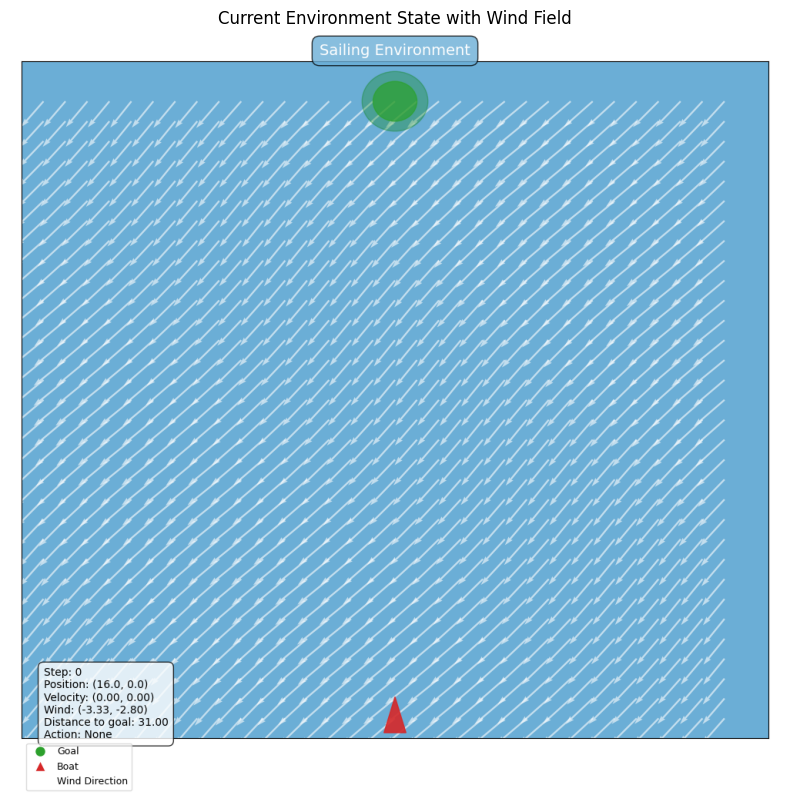


Strategy Tip: Your agent should consider:
1. Where am I relative to the goal?
2. What is my current momentum?
3. What is the wind direction and strength at my current position?
4. How does the wind field look across the environment? Where are favorable wind conditions?
5. Can I plan a route that takes advantage of favorable wind patterns?


In [7]:
# Reset the environment
observation, info = env.reset(seed=42)

# Display the observation structure
print(f"Observation shape: {observation.shape}")
print("\nObservation breakdown:")
print(f"Position (x, y): ({observation[0]:.1f}, {observation[1]:.1f})")
print(f"Velocity (vx, vy): ({observation[2]:.3f}, {observation[3]:.3f})")
print(f"Wind at position (wx, wy): ({observation[4]:.3f}, {observation[5]:.3f})")

# Calculate grid size from the wind field size
grid_size = env.grid_size
wind_field_size = grid_size[0] * grid_size[1] * 2  # x*y grid with 2 components per point
print(f"\nWind field information:")
print(f"Grid size: {grid_size}")
print(f"Flattened wind field size: {wind_field_size}")
print(f"Wind field in observation: indices 6 to {6+wind_field_size-1}")

# Display a small part of the wind field from the observation
print("\nSample of wind field data (first 10 points):")
wind_data = observation[6:26]  # Show first 10 points (each with x,y components)
for i in range(0, len(wind_data), 2):
    print(f"Grid point {i//2}: Wind (wx, wy) = ({wind_data[i]:.3f}, {wind_data[i+1]:.3f})")

# Visualize the current state
plt.figure(figsize=(10, 10))
plt.imshow(env.render())
plt.axis('off')
plt.title('Current Environment State with Wind Field')
plt.show()

print("\nStrategy Tip: Your agent should consider:")
print("1. Where am I relative to the goal?")
print("2. What is my current momentum?")
print("3. What is the wind direction and strength at my current position?")
print("4. How does the wind field look across the environment? Where are favorable wind conditions?")
print("5. Can I plan a route that takes advantage of favorable wind patterns?")

Action 0: Position: [16.  1.], Wind: [-2.6550465 -2.2099605], Reward: 0.0
Action 1: Position: [16.  0.], Wind: [-2.7455654 -2.3153987], Reward: 0.0
Action 2: Position: [16.  0.], Wind: [-2.7455654 -2.3153987], Reward: 0.0
Action 3: Position: [17.  0.], Wind: [-2.6441815 -2.2229486], Reward: 0.0
Action 4: Position: [16.  0.], Wind: [-2.7455654 -2.3153987], Reward: 0.0
Action 5: Position: [15.  0.], Wind: [-2.8952596 -2.4470093], Reward: 0.0
Action 6: Position: [15.  0.], Wind: [-2.8952596 -2.4470093], Reward: 0.0
Action 7: Position: [15.  1.], Wind: [-2.7630653 -2.2944868], Reward: 0.0
Action 8: Position: [16.  0.], Wind: [-2.7455654 -2.3153987], Reward: 0.0


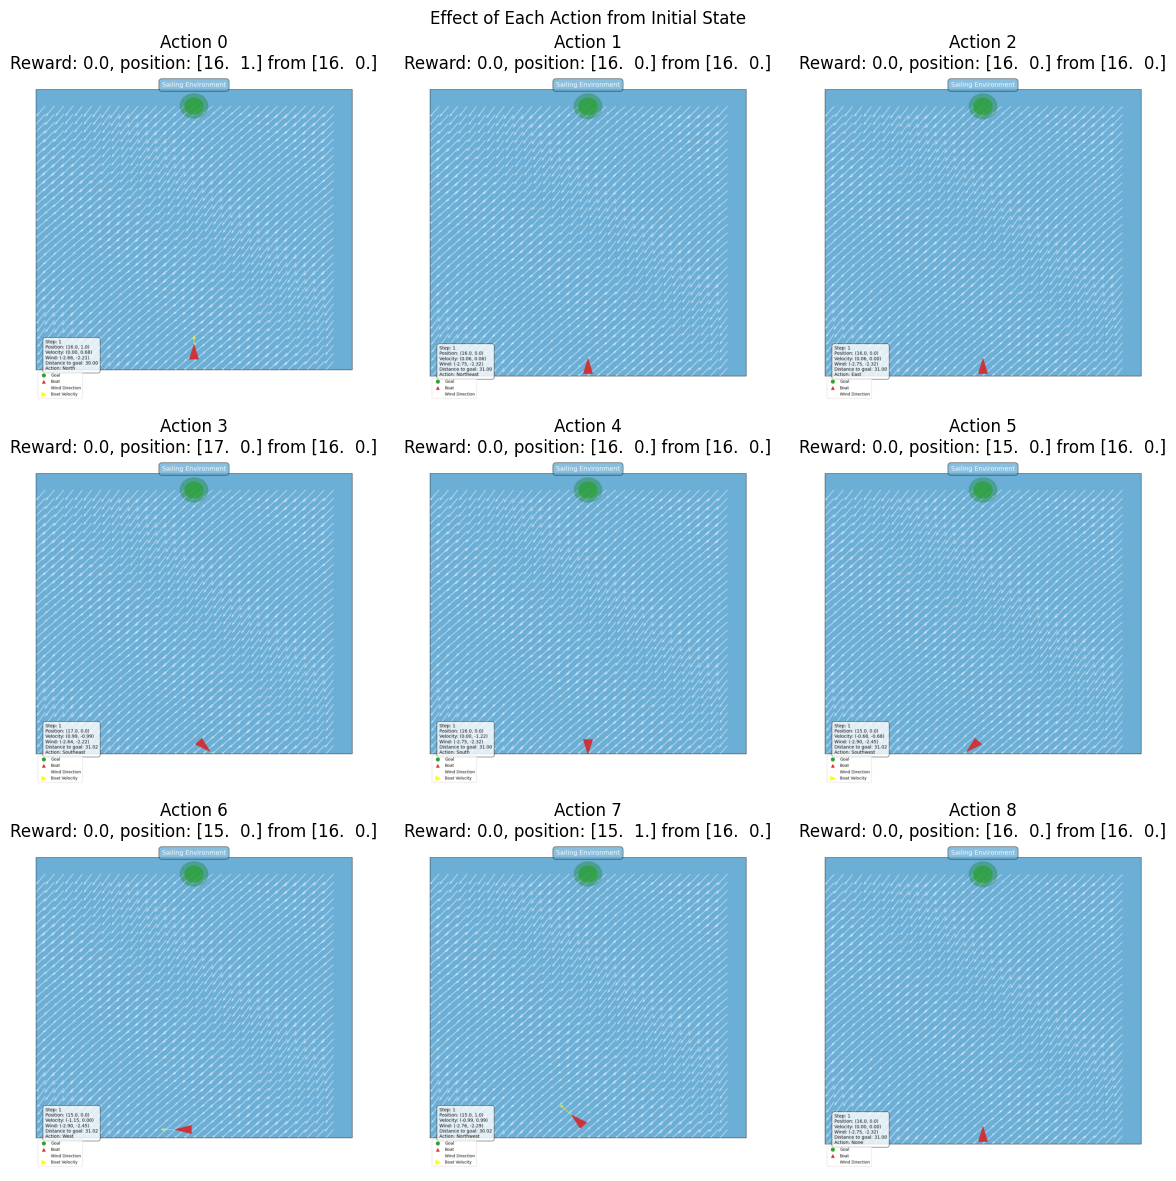

In [8]:
import matplotlib.pyplot as plt

# Reset environment to a known state
observation, info = env.reset(seed=42)

# Try each action from the current state and render the result
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()
intial_position = observation[0:2]

for action in range(9):
    # Reset to the same initial state for each action
    observation, info = env.reset(seed=42)
    # Take the action
    obs, reward, terminated, truncated, info = env.step(action)
    position= obs[0:2]
    wind = obs[4:6]
    # Print the action taken and the resulting state
    print(f"Action {action}: Position: {position}, Wind: {wind}, Reward: {reward}")
    # Render the result
    img = env.render()
    axes[action].imshow(img)
    axes[action].set_title(f"Action {action}\nReward: {reward}, position: {position} from {intial_position}")
    axes[action].axis('off')

plt.suptitle("Effect of Each Action from Initial State")
plt.tight_layout()
plt.show()

In [9]:
# import heapq
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.animation as animation
# from IPython.display import HTML

# def wind_field_from_obs(observation, grid_size):
#     wind_field_flat = observation[6:]
#     wind_grid = wind_field_flat.reshape(grid_size[0], grid_size[1], 2)
#     def wind_func(x, y):
#         x = int(np.clip(x, 0, grid_size[0]-1))
#         y = int(np.clip(y, 0, grid_size[1]-1))
#         return wind_grid[x, y]
#     return wind_func

# def sailing_a_star_env(env, start, goal, boat_performance=0.4):
#     """
#     Returns a path as a list of dicts:
#     [{'pos': (x, y), 'velocity': np.array, 'direction': np.array}, ...]
#     """
#     observation, info = env.reset(seed=42)
#     grid_size = env.grid_size
#     wind_field = wind_field_from_obs(observation, grid_size)
#     from sailing_physics import calculate_sailing_efficiency

#     def heuristic(pos):
#         return np.linalg.norm(np.array(pos) - np.array(goal)) / boat_performance

#     def get_neighbors(pos, velocity, position_accumulator):
#         neighbors = []
#         for action in range(8):  # skip "stay" for pathfinding
#             sim_pos = np.array(pos, dtype=float)
#             sim_vel = np.array(velocity, dtype=float)
#             sim_acc = np.array(position_accumulator, dtype=float)
#             direction = env._action_to_direction(action)
#             wx, wy = wind_field(sim_pos[0], sim_pos[1])
#             wind = np.array([wx, wy])
#             new_velocity = env._calculate_new_velocity(
#                 current_velocity=sim_vel,
#                 wind=wind,
#                 direction=direction
#             )
#             new_acc = sim_acc + new_velocity
#             new_position_float = sim_pos + new_acc
#             new_position = np.round(new_position_float).astype(np.int32)
#             new_acc = new_position_float - new_position
#             new_position = np.clip(
#                 new_position,
#                 [0, 0],
#                 [grid_size[0]-1, grid_size[1]-1]
#             )
#             new_pos_tuple = (int(new_position[0]), int(new_position[1]))
#             if tuple(pos) != new_pos_tuple:
#                 move_cost = np.linalg.norm(new_velocity)
#                 neighbors.append((new_pos_tuple, new_velocity, new_acc, direction, move_cost if move_cost > 0 else 1.0))
#         return neighbors

#     open_set = []
#     start_tuple = (int(round(start[0])), int(round(start[1])))
#     start_velocity = np.array([0.0, 0.0])
#     start_acc = np.array([0.0, 0.0])
#     # Path is now a list of dicts
#     heapq.heappush(open_set, (heuristic(start_tuple), 0, start_tuple, start_velocity, start_acc, [
#         {'pos': start_tuple, 'velocity': start_velocity, 'direction': np.array([0.0, 0.0])}
#     ]))
#     visited = set()
#     while open_set:
#         est_total, cost_so_far, current, velocity, acc, path = heapq.heappop(open_set)
#         if np.linalg.norm(np.array(current) - np.array(goal)) < 1.0:
#             return path
#         visited.add((current, tuple(np.round(velocity, 2)), tuple(np.round(acc, 2))))
#         for neighbor, nvel, nacc, direction, step_cost in get_neighbors(current, velocity, acc):
#             state_id = (neighbor, tuple(np.round(nvel, 2)), tuple(np.round(nacc, 2)))
#             if state_id in visited:
#                 continue
#             heapq.heappush(open_set, (
#                 cost_so_far + step_cost + heuristic(neighbor),
#                 cost_so_far + step_cost,
#                 neighbor,
#                 nvel,
#                 nacc,
#                 path + [{'pos': neighbor, 'velocity': nvel, 'direction': direction}]
#             ))
#     return None


# # Example usage:
# observation, info = env.reset(seed=42)
# start = info['position']
# goal = env.goal_position
# path = sailing_a_star_env(env, start, goal)
# print("A* Path:")
# for step in path:
#     print(f"Position: {step['pos']}, Velocity: {step['velocity']}, Direction: {step['direction']}")


In [10]:
# import numpy as np
# import heapq
# import math
# from numba import cuda, njit

# DIRECTIONS = np.array([
#     [-1, -1], [0, -1], [1, -1],
#     [-1,  0],         [1,  0],
#     [-1,  1], [0,  1], [1,  1]
# ], dtype=np.float32)

# @njit
# def heuristic(pos, goal, boat_perf):
#     return np.linalg.norm(np.array(pos) - np.array(goal)) / boat_perf

# @cuda.jit(device=True)
# def calculate_sailing_efficiency_gpu(boat_dx, boat_dy, wind_dx, wind_dy):
#     # Invert wind direction
#     wind_from_x = -wind_dx
#     wind_from_y = -wind_dy
#     # Dot product
#     dot = wind_from_x * boat_dx + wind_from_y * boat_dy
#     dot = min(1.0, max(-1.0, dot))
#     wind_angle = math.acos(dot)
#     pi = 3.141592653589793
#     if wind_angle < pi / 4:
#         return 0.05
#     elif wind_angle < pi / 2:
#         return 0.5 + 0.5 * (wind_angle - pi / 4) / (pi / 4)
#     elif wind_angle < 3 * pi / 4:
#         return 1.0
#     else:
#         eff = 1.0 - 0.5 * (wind_angle - 3 * pi / 4) / (pi / 4)
#         return max(0.5, eff)

# @cuda.jit
# def gpu_expand_neighbors(pos, velocity, acc, wind_grid, grid_size, directions, out_neighbors, out_costs):
#     i = cuda.grid(1)
#     if i >= 8:
#         return
#     dx = directions[i, 0]
#     dy = directions[i, 1]
#     x = int(pos[0])
#     y = int(pos[1])
#     gx = min(max(x, 0), grid_size[0] - 1)
#     gy = min(max(y, 0), grid_size[1] - 1)
#     wind_x = wind_grid[gx, gy, 0]
#     wind_y = wind_grid[gx, gy, 1]
#     new_velocity_x = velocity[0] + 0.1 * (wind_x + dx)
#     new_velocity_y = velocity[1] + 0.1 * (wind_y + dy)
#     new_acc_x = acc[0] + new_velocity_x
#     new_acc_y = acc[1] + new_velocity_y
#     new_pos_x = pos[0] + new_acc_x
#     new_pos_y = pos[1] + new_acc_y
#     rounded_x = int(round(new_pos_x))
#     rounded_y = int(round(new_pos_y))
#     rounded_x = max(0, min(rounded_x, grid_size[0] - 1))
#     rounded_y = max(0, min(rounded_y, grid_size[1] - 1))
#     mag = math.sqrt(dx*dx + dy*dy)
#     if mag > 0:
#         norm_dx = dx / mag
#         norm_dy = dy / mag
#     else:
#         norm_dx = 0.0
#         norm_dy = 0.0
#     wind_mag = math.sqrt(wind_x*wind_x + wind_y*wind_y)
#     if wind_mag > 0:
#         norm_wind_x = wind_x / wind_mag
#         norm_wind_y = wind_y / wind_mag
#     else:
#         norm_wind_x = 0.0
#         norm_wind_y = 0.0
#     efficiency = calculate_sailing_efficiency_gpu(norm_dx, norm_dy, norm_wind_x, norm_wind_y)
#     out_neighbors[i, 0] = rounded_x
#     out_neighbors[i, 1] = rounded_y
#     out_neighbors[i, 2] = new_velocity_x
#     out_neighbors[i, 3] = new_velocity_y
#     out_neighbors[i, 4] = new_acc_x - (rounded_x - pos[0])
#     out_neighbors[i, 5] = new_acc_y - (rounded_y - pos[1])
#     out_neighbors[i, 6] = dx
#     out_neighbors[i, 7] = dy
#     speed = math.sqrt(new_velocity_x**2 + new_velocity_y**2)
#     raw_cost = speed if speed > 0 else 1.0
#     out_costs[i] = raw_cost / efficiency

# def fast_get_neighbors_gpu(pos, velocity, acc, wind_grid, grid_size):
#     directions = DIRECTIONS
#     out_neighbors = np.zeros((8, 8), dtype=np.float32)
#     out_costs = np.zeros(8, dtype=np.float32)
#     threadsperblock = 8
#     blockspergrid = 1
#     gpu_expand_neighbors[blockspergrid, threadsperblock](
#         pos.astype(np.float32), velocity.astype(np.float32), acc.astype(np.float32),
#         wind_grid.astype(np.float32), np.array(grid_size, dtype=np.int32),
#         directions, out_neighbors, out_costs
#     )
#     neighbors = []
#     for i in range(8):
#         neighbor_pos = (int(out_neighbors[i, 0]), int(out_neighbors[i, 1]))
#         nvel = out_neighbors[i, 2:4]
#         nacc = out_neighbors[i, 4:6]
#         direction = out_neighbors[i, 6:8]
#         step_cost = out_costs[i]
#         if neighbor_pos != (int(pos[0]), int(pos[1])):
#             neighbors.append((neighbor_pos, nvel, nacc, direction, step_cost))
#     return neighbors

# # Use fast_get_neighbors_gpu in your A* loop as you already do.

# import time

# def sailing_a_star_env(env, start, goal, boat_performance=0.4):
#     t0 = time.perf_counter()
#     observation, info = env.reset(seed=42)
#     grid_size = env.grid_size
#     wind_field_flat = observation[6:]
#     wind_grid = wind_field_flat.reshape(grid_size[0], grid_size[1], 2)
#     def heuristic_fn(pos):
#         return np.linalg.norm(np.array(pos) - np.array(goal)) / boat_performance
#     open_set = []
#     start_tuple = (int(round(start[0])), int(round(start[1])))
#     start_velocity = np.array([0.0, 0.0])
#     start_acc = np.array([0.0, 0.0])
#     heapq.heappush(open_set, (heuristic_fn(start_tuple), 0, start_tuple, start_velocity, start_acc, [
#         {'pos': start_tuple, 'velocity': start_velocity, 'direction': np.array([0.0, 0.0])}
#     ]))
#     visited = set()
#     t1 = time.perf_counter()
#     while open_set:
#         t2 = time.perf_counter()
#         est_total, cost_so_far, current, velocity, acc, path = heapq.heappop(open_set)
#         t3 = time.perf_counter()
#         if np.linalg.norm(np.array(current) - np.array(goal)) < 1.0:
#             print(f"Total time: {time.perf_counter() - t0:.4f}s")
#             print(f"Setup time: {t1 - t0:.4f}s")
#             print(f"Loop time: {time.perf_counter() - t1:.4f}s")
#             return path
#         visited.add((current, tuple(np.round(velocity, 2)), tuple(np.round(acc, 2))))
#         t4 = time.perf_counter()
#         neighbors = fast_get_neighbors_gpu(np.array(current), velocity, acc, wind_grid, grid_size)
#         t5 = time.perf_counter()
#         for neighbor, nvel, nacc, direction, step_cost in neighbors:
#             state_id = (neighbor, tuple(np.round(nvel, 2)), tuple(np.round(nacc, 2)))
#             if state_id in visited:
#                 continue
#             heapq.heappush(open_set, (
#                 cost_so_far + step_cost + heuristic_fn(neighbor),
#                 cost_so_far + step_cost,
#                 neighbor,
#                 nvel,
#                 nacc,
#                 path + [{'pos': neighbor, 'velocity': nvel, 'direction': direction}]
#             ))
#         t6 = time.perf_counter()
#         # Print timing for each major section in the loop
#         print(f"heappop: {t3-t2:.6f}s, neighbors: {t5-t4:.6f}s, push: {t6-t5:.6f}s")
#     print(f"Total time: {time.perf_counter() - t0:.4f}s")
#     return None

# # Example usage:
# observation, info = env.reset(seed=42)
# start = info['position']
# goal = env.goal_position
# path = sailing_a_star_env(env, start, goal)
# print("A* Path:")
# for step in path:
#     print(f"Position: {step['pos']}, Velocity: {step['velocity']}, Direction: {step['direction']}")

In [11]:
# def plot_a_star_arrows(env, path, observation):
#     """
#     Plot the A* path as arrows showing direction and speed at each step,
#     with intermediary positions colored in a gradient.
#     """
#     import matplotlib.cm as cm

#     grid_size = env.grid_size
#     wind_field_flat = observation[6:]
#     wind_grid = wind_field_flat.reshape(grid_size[0], grid_size[1], 2)
#     X, Y = np.meshgrid(np.arange(grid_size[0]), np.arange(grid_size[1]))
#     U = wind_grid[:, :, 0].T
#     V = wind_grid[:, :, 1].T

#     fig, ax = plt.subplots(figsize=(7, 7))
#     ax.set_xlim(0, grid_size[0])
#     ax.set_ylim(0, grid_size[1])
#     ax.set_title("A* Path: Boat Direction and Speed (Gradient)")

#     ax.quiver(X, Y, U, V, color='blue', alpha=0.3)
#     start = path[0]['pos']
#     goal = path[-1]['pos']
#     ax.plot(start[0]+0.5, start[1]+0.5, 'go', markersize=10, label="Start")
#     ax.plot(goal[0]+0.5, goal[1]+0.5, 'ro', markersize=10, label="Goal")

#     # Gradient colors for intermediary positions
#     n = len(path)
#     cmap = cm.get_cmap('viridis')
#     for i, step in enumerate(path):
#         pos = np.asarray(step['pos'])
#         velocity = np.asarray(step['velocity'])
#         color = cmap(i / (n-1)) if n > 1 else 'black'
#         # Draw intermediary position
#         ax.plot(pos[0]+0.5, pos[1]+0.5, marker='o', color=color, markersize=6, alpha=0.8)
#         # Draw velocity arrow if nonzero
#         if np.linalg.norm(velocity) > 1e-3:
#             ax.arrow(
#                 pos[0]+0.5, pos[1]+0.5,
#                 velocity[0], velocity[1],
#                 color=color, width=0.05, head_width=0.5, length_includes_head=True, alpha=0.7
#             )

#     ax.legend()
#     plt.show()

# # Usage:
# if path:
#     plot_a_star_arrows(env, path, observation)
# else:
#     print("No path found!")

### Visualizing Environment State from Observations

The `SailingEnv.visualize_observation()` function allows you to create a complete visualization of the environment from any observation. This is particularly useful for:

1. **Understanding the current state** of the sailing environment
2. **Debugging agent behavior** by visualizing key decision points
3. **Analyzing wind patterns** across the entire grid

This visualization includes the boat position, velocity, wind field, and goal location in a format identical to the environment's built-in render method.

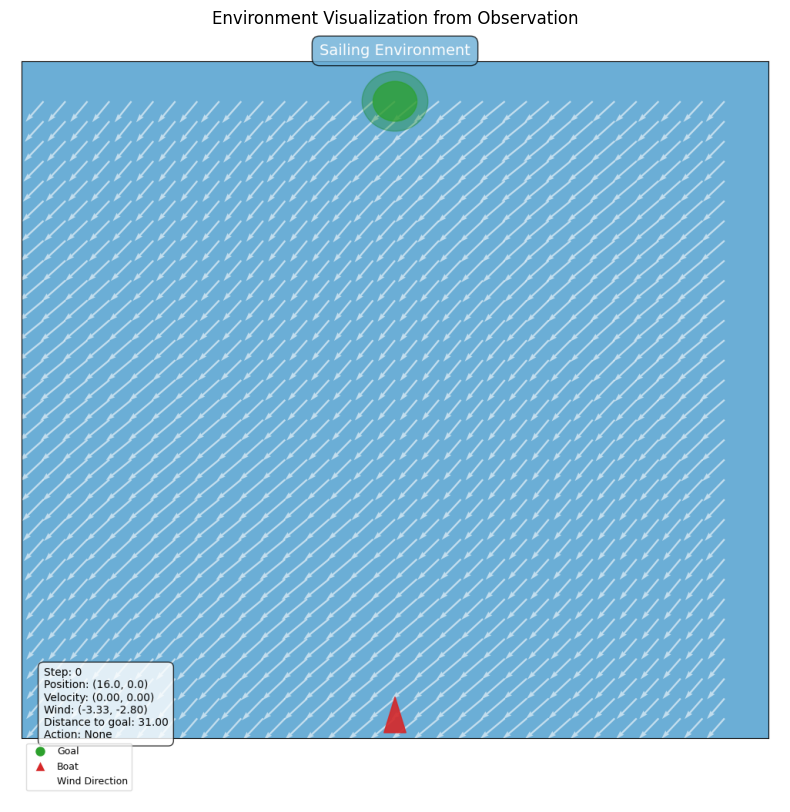

In [12]:
# Visualize the observation as an image
plt.figure(figsize=(10, 10))
img = SailingEnv.visualize_observation(observation)  # Call as a class method
plt.imshow(img)
plt.axis('off')
plt.title('Environment Visualization from Observation')
plt.show()

## 6. Rewards and Goal

Now let's understand how success is measured in the sailing environment.

### Reward Structure

The sailing environment provides rewards as follows:

- **Reaching the goal**: Large positive reward (100.0)
- **Other steps**: No reward (0.0)

This is a sparse reward structure, which makes the problem challenging. Your agent only receives feedback when it successfully reaches the goal.

### Discounted Reward

In reinforcement learning, we often use **discounted rewards** to emphasize immediate rewards over future ones. The discounted reward is calculated as:

$$R_{discounted} = \sum_{t=0}^{T} \gamma^t r_t$$

Where:
- $r_t$ is the reward at time step $t$
- $\gamma$ is the discount factor ($\gamma=0.99$ in our environment)
- $T$ is the total number of time steps

This means reaching the goal quickly results in a higher discounted reward than reaching it slowly.

### Episode Termination

An episode ends when:

1. The agent reaches the goal (success)
2. The maximum number of steps is reached (typically 200 steps)

Let's run a simple example to see the reward mechanism in action:

In [13]:
# Reset the environment
observation, info = env.reset(seed=42)

# Set up tracking
rewards = []
steps_to_goal = 0
discount_factor = 0.99  # The standard discount factor
reached_goal = False

# Manually move the boat toward the goal
print("Taking steps toward the goal...")
for step in range(1, 500):  # Increased to 500 steps to ensure we reach the goal
    # Always choose action 0 (North) for this demo
    action = 0  # Move North
    
    # Take a step
    observation, reward, terminated, truncated, info = env.step(action)
    
    # Track reward
    rewards.append(reward)
    
    # Report every 50 steps
    if step % 50 == 0:
        print(f"Step {step}: Position {info['position']}, Reward: {reward}")
    
    # Check if we're done
    if terminated and reward > 0:  # If terminated due to reaching the goal
        reached_goal = True
        steps_to_goal = step
        print(f"\nGoal reached at step {step}!")
        print(f"Final position: {info['position']}")
        print(f"Goal reward: {reward}")
        break
        
    if truncated:
        print(f"\nEpisode truncated at step {step} without reaching goal")
        break

# Calculate discounted reward
if reached_goal:
    # All rewards are 0 except the last one (which is 100)
    discounted_reward = 100 * (discount_factor ** (steps_to_goal - 1))
    
    print(f"\nDiscounted Reward Calculation:")
    print(f"- Raw goal reward: 100")
    print(f"- Discount factor: {discount_factor}")
    print(f"- Steps to goal: {steps_to_goal}")
    print(f"- Discounted reward: {discounted_reward:.2f}")
    
    # Show what would happen with different numbers of steps
    print("\nComparison of discounted rewards with different step counts:")
    for test_steps in [25, 50, 100, 150, 200]:
        test_reward = 100 * (discount_factor ** (test_steps - 1))
        print(f"- Reaching goal in {test_steps} steps: {test_reward:.2f}")
else:
    print("\nFailed to reach the goal in the allotted steps.")
    print("Discounted reward: 0.00")

Taking steps toward the goal...
Step 50: Position [16  6], Reward: 0.0
Step 100: Position [16 10], Reward: 0.0

Goal reached at step 118!
Final position: [16 30]
Goal reward: 100.0

Discounted Reward Calculation:
- Raw goal reward: 100
- Discount factor: 0.99
- Steps to goal: 118
- Discounted reward: 30.85

Comparison of discounted rewards with different step counts:
- Reaching goal in 25 steps: 78.57
- Reaching goal in 50 steps: 61.11
- Reaching goal in 100 steps: 36.97
- Reaching goal in 150 steps: 22.37
- Reaching goal in 200 steps: 13.53


## 7. Initial Windfields

As mentioned earlier, the sailing challenge includes different wind conditions that your agent will need to handle. Let's load and visualize each of the training initial windfields to understand their unique characteristics.

### Training Initial Windfields

The training initial windfields are designed to expose your agent to different starting wind patterns:

- Each initial windfield has a unique starting configuration (base direction, pattern scale, strength variation)
- All windfields evolve over time according to the same underlying dynamics
- Your agent must learn to adapt to both the initial conditions and how they change during an episode

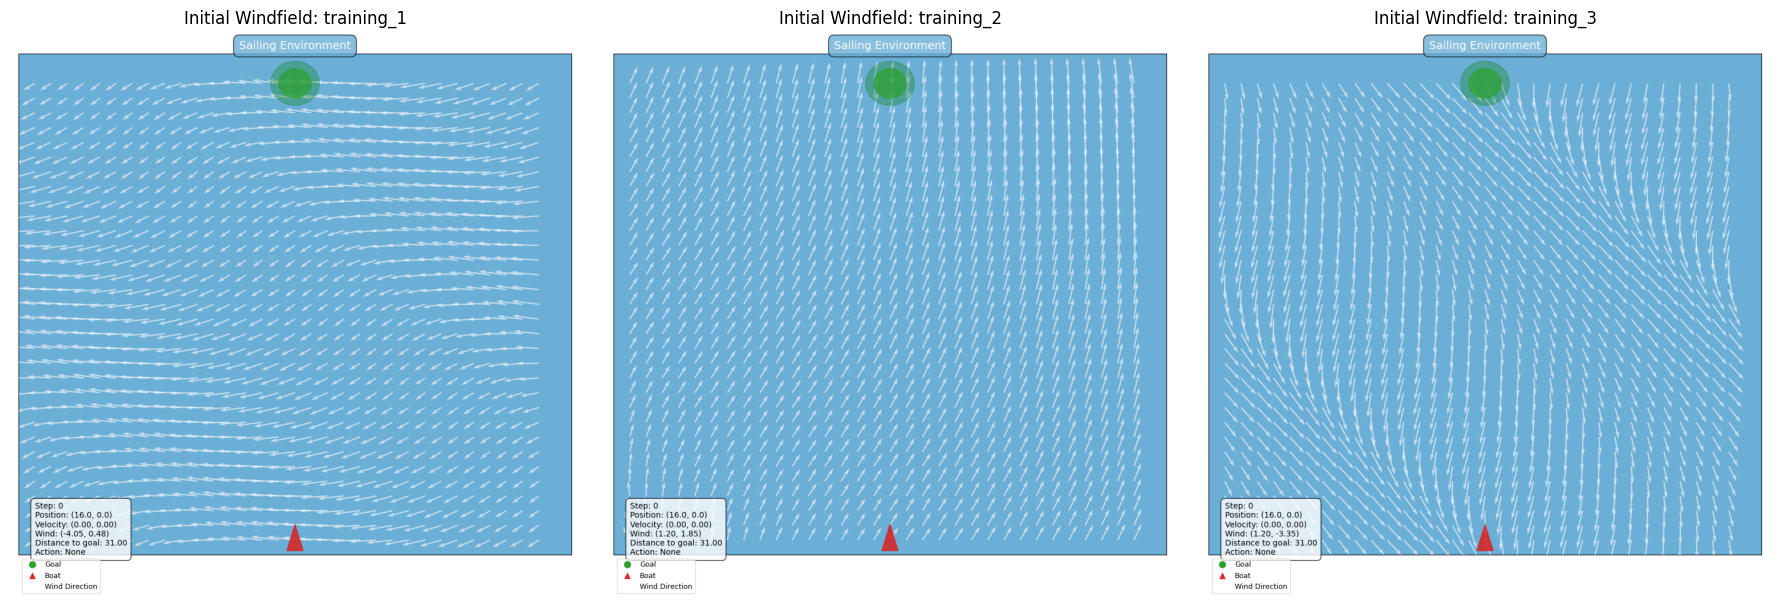

Training Initial Windfield 1: North-Northwest Wind
- Starting with North-Northwest wind direction

Training Initial Windfield 2: North-Northeast Wind
- Starting with North-Northeast wind direction

Training Initial Windfield 3: West Wind
- Starting with predominantly West wind direction

Test Initial Windfield: Hidden
- Not accessible during development
- Your agent will be evaluated on this initial condition
- Different starting configuration but evolves according to the same rules


In [14]:
# Load each training initial windfield and visualize its wind pattern
training_windfields = {
    "training_1": get_initial_windfield("training_1"),
    "training_2": get_initial_windfield("training_2"),
    "training_3": get_initial_windfield("training_3")
}

# Add visualization parameters to each initial windfield
viz_params = {
    'env_params': {
        'wind_grid_density': 25,
        'wind_arrow_scale': 80,
        'render_mode': "rgb_array"
    }
}

# Create a figure for each initial windfield
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, (name, windfield) in enumerate(training_windfields.items()):
    # Create a copy with visualization parameters
    viz_windfield = windfield.copy()
    viz_windfield.update(viz_params)
    
    # Create environment with this initial windfield
    env = SailingEnv(
        wind_init_params=viz_windfield['wind_init_params'],
        wind_evol_params=viz_windfield['wind_evol_params'],
        wind_grid_density=25,
        wind_arrow_scale=80,
        render_mode="rgb_array"
    )
    
    # Reset and render
    env.reset(seed=42)
    
    # Display the image
    axes[i].imshow(env.render())
    axes[i].set_title(f"Initial Windfield: {name}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Print initial windfield descriptions
print("Training Initial Windfield 1: North-Northwest Wind")
print("- Starting with North-Northwest wind direction")
print("\nTraining Initial Windfield 2: North-Northeast Wind")
print("- Starting with North-Northeast wind direction")
print("\nTraining Initial Windfield 3: West Wind")
print("- Starting with predominantly West wind direction")
print("\nTest Initial Windfield: Hidden")
print("- Not accessible during development")
print("- Your agent will be evaluated on this initial condition")
print("- Different starting configuration but evolves according to the same rules")

## 8. Wind Evolution

The wind doesn't remain static during an episode - it evolves over time according to common evolution parameters shared by all initial windfields. Let's visualize how wind changes over several steps in an initial windfield:

> **Note**: For debugging purposes, there's a special `simple_static` initial windfield available through `get_initial_windfield("simple_static")` that maintains completely static wind conditions. This is an exception to the rule - all training and test initial windfields evolve over time according to the same underlying dynamics, while this static version keeps wind constant to help with basic agent testing.

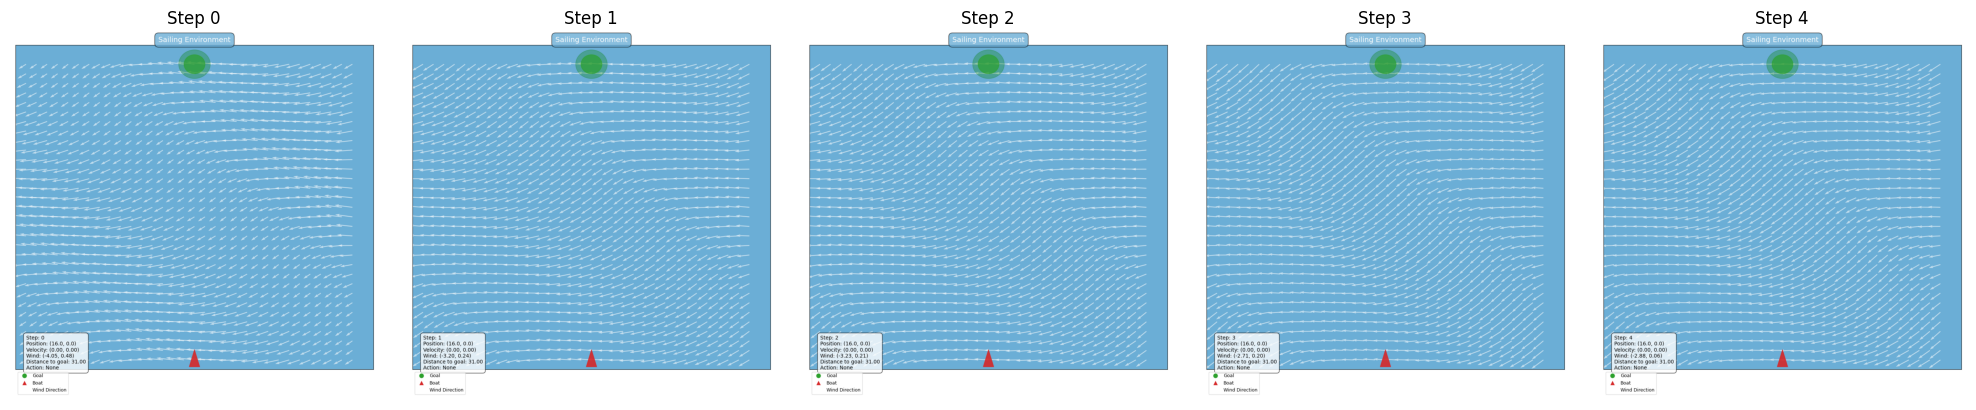

Notice how the wind pattern changes over time!
- Wind direction and strength evolve according to the common evolution parameters
- This evolution is the same for all training and test initial windfields
- Your agent must adapt to these changing conditions while navigating
- For debugging, you can use get_initial_windfield('simple_static') which has static wind


In [15]:
# Create an environment with the first training initial windfield
initial_windfield = get_initial_windfield("training_1")
initial_windfield.update(viz_params)

env = SailingEnv(
    wind_init_params=initial_windfield['wind_init_params'],
    wind_evol_params=initial_windfield['wind_evol_params'],
    wind_grid_density=25,
    wind_arrow_scale=80,
    render_mode="rgb_array"
)

# Reset the environment
env.reset(seed=42)

# Capture wind evolution over several steps
wind_frames = []
for step in range(5):  # Capture 5 frames
    # Render current state
    frame = env.render()
    wind_frames.append(frame)
    
    # Take a "stay in place" action to let wind evolve
    env.step(8)  # Action 8 is "stay in place"

# Display the frames
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, frame in enumerate(wind_frames):
    axes[i].imshow(frame)
    axes[i].set_title(f"Step {i}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

print("Notice how the wind pattern changes over time!")
print("- Wind direction and strength evolve according to the common evolution parameters")
print("- This evolution is the same for all training and test initial windfields")
print("- Your agent must adapt to these changing conditions while navigating")
print("- For debugging, you can use get_initial_windfield('simple_static') which has static wind")

In [ ]:
wind_fields = []
observation, info = env.reset(seed=42)
grid_size = env.grid_size
wind_field = observation[6:].reshape(grid_size[0], grid_size[1], 2)
wind_fields.append(wind_field.copy())
# Simulate wind evolution over 200 steps
for step in range(200):
    obs = env.step(8)[0]  # Action 8 is "stay in place"
    grid_size = env.grid_size
    wind_field = obs[6:].reshape(grid_size[0], grid_size[1], 2)
    wind_fields.append(wind_field.copy())
    env.step(8)

mean_mag_changes = []
max_mag_changes = []
mean_ang_changes = []
max_ang_changes = []

for i in range(1, len(wind_fields)):
    u = wind_fields[i - 1]
    v = wind_fields[i]
    diff = v - u
    mag_change = np.linalg.norm(diff, axis=2)
    mean_mag_changes.append(np.mean(mag_change))
    max_mag_changes.append(np.max(mag_change))
    
    ang = angle_diff(u, v)
    mean_ang_changes.append(np.degrees(np.mean(ang)))
    max_ang_changes.append(np.degrees(np.max(ang)))


def angle_diff(u, v):
    # u, v: (..., 2)
    dot = np.sum(u * v, axis=-1)
    norm_u = np.linalg.norm(u, axis=-1)
    norm_v = np.linalg.norm(v, axis=-1)
    cos_theta = np.clip(dot / (norm_u * norm_v + 1e-8), -1, 1)
    return np.arccos(cos_theta)

for i in range(1, len(wind_fields)):
    u = wind_fields[i-1]
    v = wind_fields[i]
    ang = angle_diff(u, v)
    mean_ang = np.degrees(np.mean(ang))
    max_ang = np.degrees(np.max(ang))
    print(f"Step {i-1} → {i}: mean wind angle change = {mean_ang:.2f}°, max = {max_ang:.2f}°")

Top wind magnitude changes:


NameError: name 'top_mag_indices' is not defined

Top wind magnitude changes:


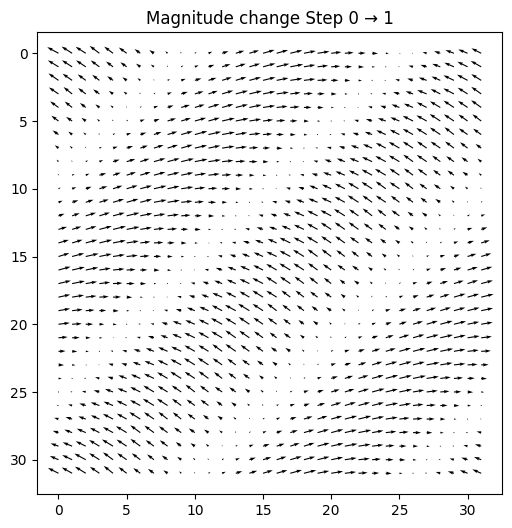

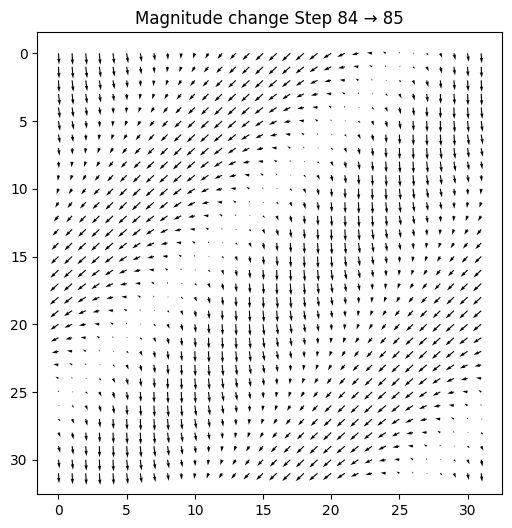

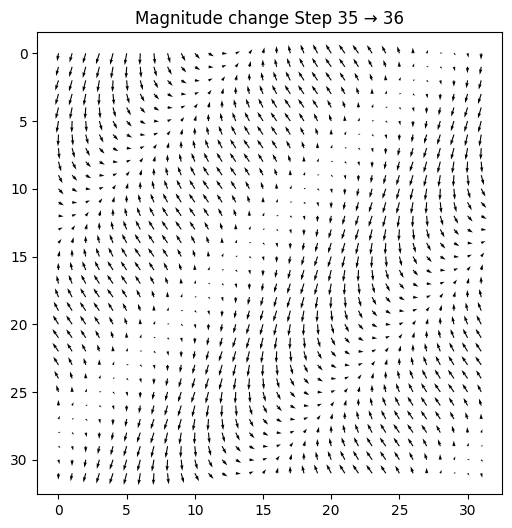

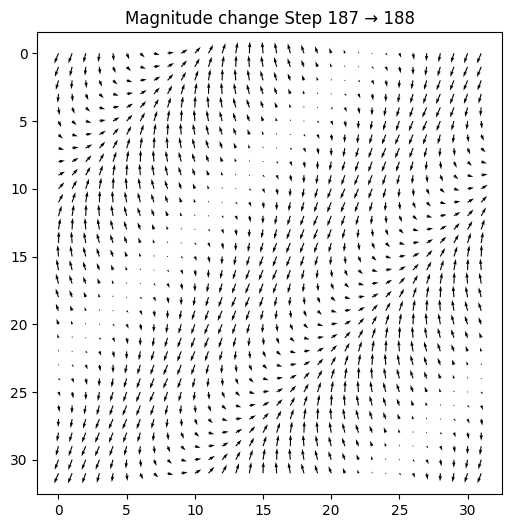

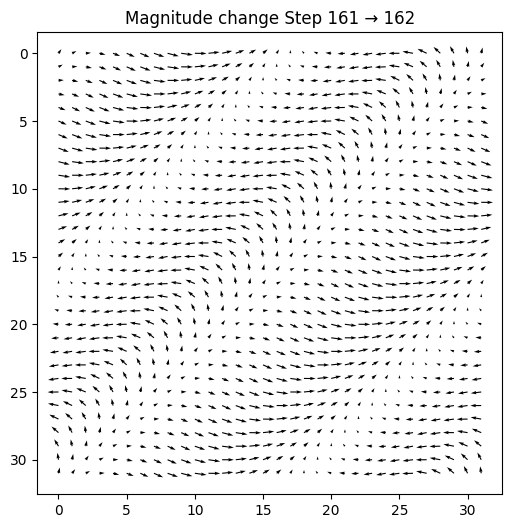

Top wind angle changes:


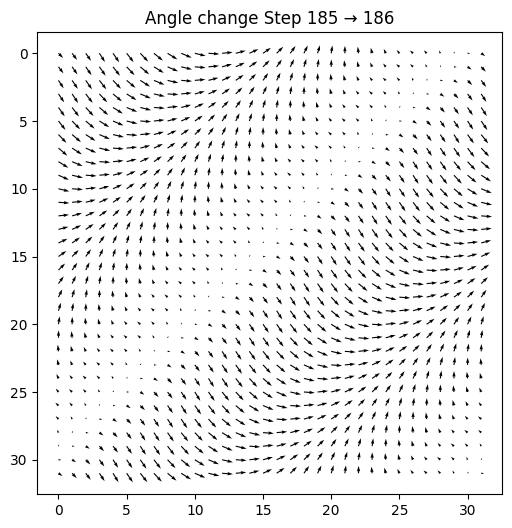

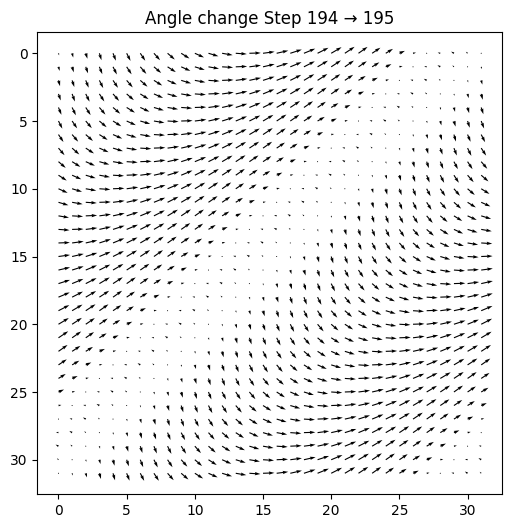

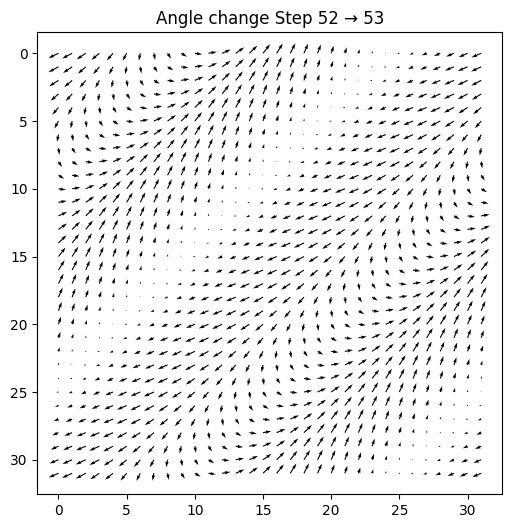

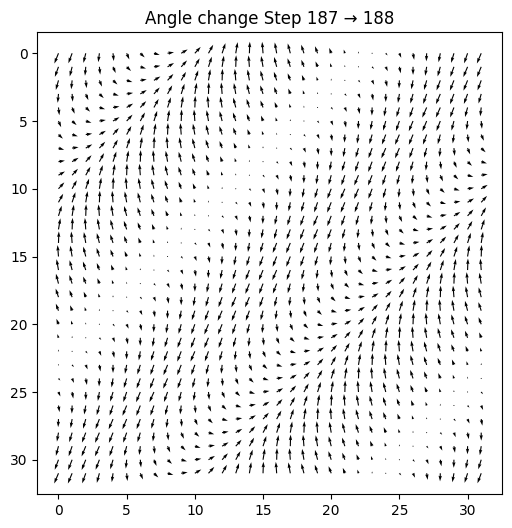

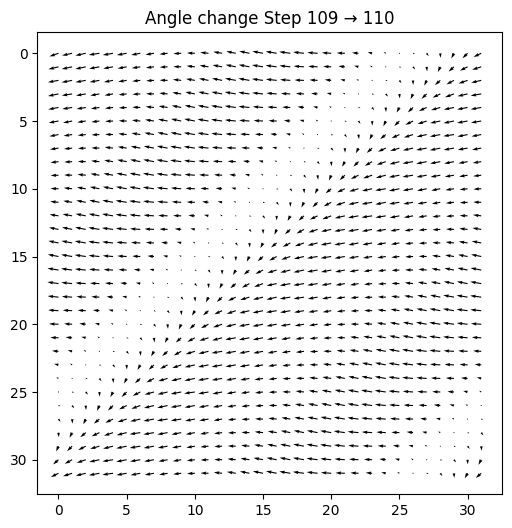

In [ ]:
import heapq

k = 5  # number of frames to visualize

top_mag_indices = heapq.nlargest(k, range(len(mean_mag_changes)), key=lambda i: mean_mag_changes[i])
top_ang_indices = heapq.nlargest(k, range(len(mean_ang_changes)), key=lambda i: mean_ang_changes[i])
import matplotlib.pyplot as plt

def plot_wind_difference(before, after, title):
    diff = after - before
    X, Y = np.meshgrid(np.arange(diff.shape[1]), np.arange(diff.shape[0]))
    U = diff[:, :, 0]
    V = diff[:, :, 1]
    
    plt.figure(figsize=(6, 6))
    plt.quiver(X, Y, U, V, angles='xy')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()
    
print("Top wind magnitude changes:")
for idx in top_mag_indices:
    plot_wind_difference(wind_fields[idx], wind_fields[idx+1], f"Magnitude change Step {idx} → {idx+1}")

print("Top wind angle changes:")
for idx in top_ang_indices:
    plot_wind_difference(wind_fields[idx], wind_fields[idx+1], f"Angle change Step {idx} → {idx+1}")




## 9. Conclusion and Next Steps

Congratulations! You now have a comprehensive understanding of the sailing environment:

✅ You understand the physics of sailing and how wind angle affects efficiency  
✅ You know the action space and how controls work  
✅ You understand the observation space and what information is available to your agent  
✅ You've seen how rewards are structured  
✅ You're familiar with the different initial windfields and how they evolve over time  

### Next Steps

1. Move on to the next notebook to learn about creating and testing your agent
2. Experiment with different strategies for navigating in various wind conditions
3. Think about how to handle the "no-go zone" when sailing upwind
4. Consider how to optimize your path given the initial wind conditions and their evolution

Remember, the key challenge is creating an agent that can generalize across different initial windfields, particularly the hidden test initial windfield. Your agent needs to adapt both to the starting wind configurations and how they change over time. Good luck with your sailing agent!

/tmp/ipykernel_2317/968706242.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')
/tmp/ipykernel_2317/968706242.py:43: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


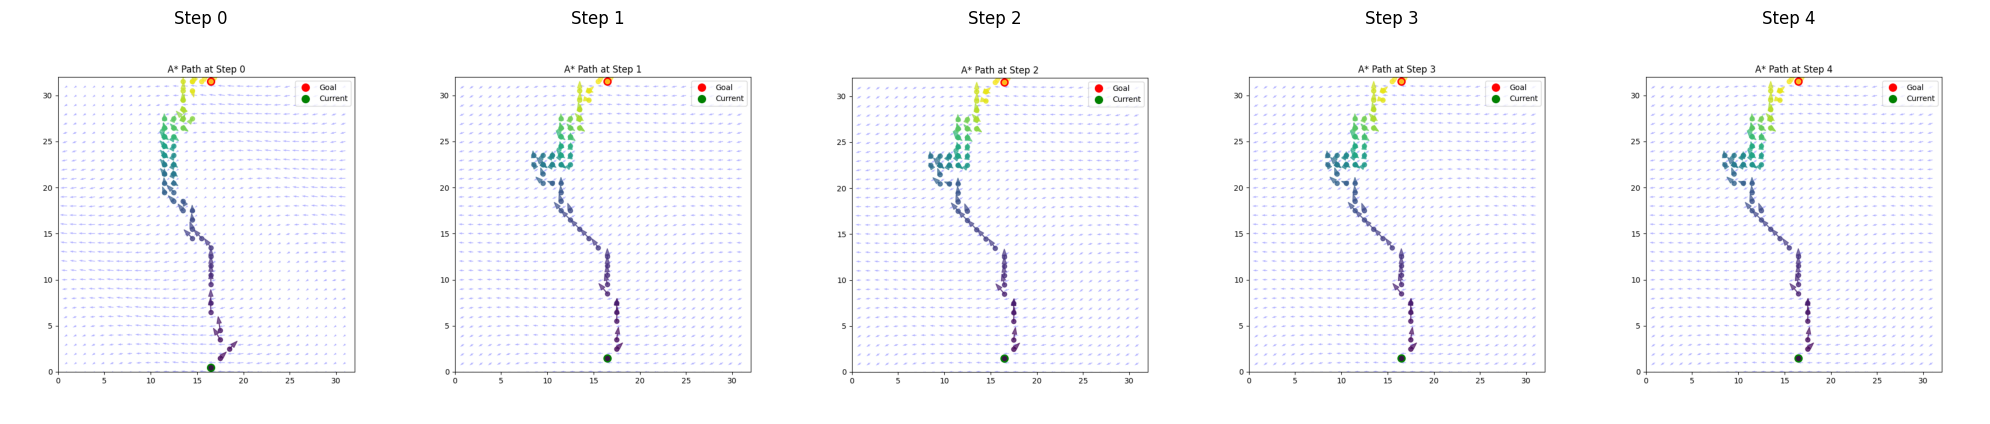

In [ ]:
# Visualize how the greedy A* path adapts as the wind changes
def plot_greedy_a_star_evolution(env, steps=5):
    obs, info = env.reset(seed=42)
    frames = []
    positions = [obs[:2].copy()]
    for step in range(steps):
        # Compute A* path from current position
        path = sailing_a_star_env(env, obs[:2], env.goal_position)
        # Render wind field and overlay A* path
        fig, ax = plt.subplots(figsize=(7, 7))
        grid_size = env.grid_size
        wind_field_flat = obs[6:]
        wind_grid = wind_field_flat.reshape(grid_size[0], grid_size[1], 2)
        X, Y = np.meshgrid(np.arange(grid_size[0]), np.arange(grid_size[1]))
        U = wind_grid[:, :, 0].T
        V = wind_grid[:, :, 1].T
        ax.quiver(X, Y, U, V, color='blue', alpha=0.3)
        ax.set_xlim(0, grid_size[0])
        ax.set_ylim(0, grid_size[1])
        ax.set_title(f"A* Path at Step {step}")
        # Plot start and goal
        ax.plot(env.goal_position[0]+0.5, env.goal_position[1]+0.5, 'ro', markersize=10, label="Goal")
        ax.plot(obs[0]+0.5, obs[1]+0.5, 'go', markersize=10, label="Current")
        # Plot A* path with gradient
        if path:
            import matplotlib.cm as cm
            n = len(path)
            cmap = cm.get_cmap('viridis')
            for i, step_dict in enumerate(path):
                pos = np.asarray(step_dict['pos'])
                velocity = np.asarray(step_dict['velocity'])
                color = cmap(i / (n-1)) if n > 1 else 'black'
                ax.plot(pos[0]+0.5, pos[1]+0.5, marker='o', color=color, markersize=6, alpha=0.8)
                if np.linalg.norm(velocity) > 1e-3:
                    ax.arrow(
                        pos[0]+0.5, pos[1]+0.5,
                        velocity[0], velocity[1],
                        color=color, width=0.05, head_width=0.5, length_includes_head=True, alpha=0.7
                    )
        ax.legend()
        fig.canvas.draw()
        # Convert to numpy array for display
        frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        frames.append(frame)
        plt.close(fig)
        # Take greedy step (if possible)
        if path is None or len(path) < 2:
            break
        # Choose action toward first step in path
        first_step = path[1]
        action = None
        for a in range(8):
            direction = env._action_to_direction(a)
            expected_pos = np.round(obs[:2] + direction).astype(int)
            if np.allclose(expected_pos, first_step['pos'], atol=1):
                action = a
                break
        if action is None:
            delta = np.array(first_step['pos']) - obs[:2]
            action = np.argmax([np.dot(env._action_to_direction(a), delta) for a in range(8)])
        obs, reward, terminated, truncated, info = env.step(action)
        positions.append(obs[:2].copy())
        if terminated:
            break
    # Display the frames
    fig, axes = plt.subplots(1, len(frames), figsize=(4*len(frames), 6))
    if len(frames) == 1:
        axes = [axes]
    for i, frame in enumerate(frames):
        axes[i].imshow(frame)
        axes[i].set_title(f"Step {i}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# Usage:
plot_greedy_a_star_evolution(env, steps=5)

In [ ]:
import heapq
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

def wind_field_from_obs(observation, grid_size):
    wind_field_flat = observation[6:]
    wind_grid = wind_field_flat.reshape(grid_size[0], grid_size[1], 2)
    def wind_func(x, y):
        x = int(np.clip(x, 0, grid_size[0]-1))
        y = int(np.clip(y, 0, grid_size[1]-1))
        return wind_grid[x, y]
    return wind_func

def sailing_a_star_env_action(env, start, goal, boat_performance=0.4):
    """
    Returns a path as a list of dicts:
    [{'pos': (x, y), 'velocity': np.array, 'direction': np.array}, ...]
    """
    grid_size = env.grid_size
    wind_field = wind_field_from_obs(observation, grid_size)
    from sailing_physics import calculate_sailing_efficiency

    def heuristic(pos):
        return np.linalg.norm(np.array(pos) - np.array(goal)) / boat_performance

    def get_neighbors(pos, velocity, position_accumulator):
        neighbors = []
        for action in range(9):  # skip "stay" for pathfinding
            sim_pos = np.array(pos, dtype=float)
            sim_vel = np.array(velocity, dtype=float)
            sim_acc = np.array(position_accumulator, dtype=float)
            direction = env._action_to_direction(action)
            wx, wy = wind_field(sim_pos[0], sim_pos[1])
            wind = np.array([wx, wy])
            new_velocity = env._calculate_new_velocity(
                current_velocity=sim_vel,
                wind=wind,
                direction=direction
            )
            new_acc = sim_acc + new_velocity
            new_position_float = sim_pos + new_acc
            new_position = np.round(new_position_float).astype(np.int32)
            new_acc = new_position_float - new_position
            new_position = np.clip(
                new_position,
                [0, 0],
                [grid_size[0]-1, grid_size[1]-1]
            )
            new_pos_tuple = (int(new_position[0]), int(new_position[1]))
            
            move_cost = 1.0
            neighbors.append((new_pos_tuple, new_velocity, new_acc, direction, move_cost if move_cost > 0 else 1.0))
        return neighbors

    open_set = []
    start_tuple = (int(round(start[0])), int(round(start[1])))
    start_velocity = np.array([env.velocity[0], env.velocity[1]])
    start_acc = np.array([env.position_accumulator[0], env.position_accumulator[1]])
    print(f"Start velocity: {start_velocity}, Start acc: {start_acc}")
    # Path is now a list of dicts
    heapq.heappush(open_set, (heuristic(start_tuple), 0, start_tuple, start_velocity, start_acc, [
        {'pos': start_tuple, 'velocity': start_velocity, 'direction': np.array([0.0, 0.0])}
    ]))
    visited = set()
    while open_set:
        est_total, cost_so_far, current, velocity, acc, path = heapq.heappop(open_set)
        if np.linalg.norm(np.array(current) - np.array(goal)) < 1.0:
            return path
        visited.add((current, tuple(np.round(velocity, 2)), tuple(np.round(acc, 2))))
        for neighbor, nvel, nacc, direction, step_cost in get_neighbors(current, velocity, acc):
            state_id = (tuple(neighbor), tuple(np.round(nvel, 2)), tuple(np.round(nacc, 2)))
            if state_id in visited:
                continue
            heapq.heappush(open_set, (
            cost_so_far + step_cost + heuristic(neighbor),
            cost_so_far + step_cost,
            tuple(neighbor),
            tuple(nvel),
            tuple(nacc),
            path + [{'pos': tuple(neighbor), 'velocity': tuple(nvel), 'direction': tuple(direction)}]
        ))
    return None


# Example usage:
observation, info = env.reset(seed=42)
start = env.position
goal = env.goal_position
path = sailing_a_star_env_action(env, start, goal)
print("A* Path:")
for step in path:
    print(f"Position: {step['pos']}, Velocity: {step['velocity']}, Direction: {step['direction']}")


Start velocity: [0. 0.], Start acc: [0. 0.]
A* Path:
Position: (16, 0), Velocity: [0. 0.], Direction: [0. 0.]
Position: (16, 1), Velocity: (np.float64(0.0), np.float64(1.1571713447570802)), Direction: (np.int64(0), np.int64(1))
Position: (16, 3), Velocity: (np.float64(0.0), np.float64(1.5262398052215576)), Direction: (np.int64(0), np.int64(1))
Position: (16, 4), Velocity: (np.float64(0.0), np.float64(1.6199070825576782)), Direction: (np.int64(0), np.int64(1))
Position: (16, 6), Velocity: (np.float64(0.0), np.float64(1.630956839028911)), Direction: (np.int64(0), np.int64(1))
Position: (16, 7), Velocity: (np.float64(0.0), np.float64(1.4744324772736854)), Direction: (np.int64(0), np.int64(1))
Position: (16, 9), Velocity: (np.float64(0.0), np.float64(1.3592592863758333)), Direction: (np.int64(0), np.int64(1))
Position: (16, 10), Velocity: (np.float64(0.0), np.float64(1.154119947914999)), Direction: (np.int64(0), np.int64(1))
Position: (16, 11), Velocity: (np.float64(0.0), np.float64(1.0189

In [ ]:
import numpy as np
import heapq
from numba import njit

@njit
def calculate_new_velocity_numba(current_velocity, wind, direction, boat_performance, max_speed, inertia_factor):
    wind_norm = np.sqrt(wind[0]**2 + wind[1]**2)
    new_velocity = np.zeros(2, dtype=np.float32)
    wind_normalized = np.array([0.0, 0.0], dtype=np.float32)
    sailing_efficiency = 0.0

    if wind_norm > 0.0:
        wind_normalized = wind / wind_norm

        direction_norm = np.sqrt(direction[0]**2 + direction[1]**2)
        if direction_norm < 1e-10:
            direction_normalized = np.array([1.0, 0.0], dtype=np.float32)
        else:
            direction_normalized = direction / direction_norm

        dot = direction_normalized[0] * -wind_normalized[0] + direction_normalized[1] * -wind_normalized[1]
        angle = np.arccos(min(1.0, max(-1.0, dot)))

        if angle < np.pi / 4:
            sailing_efficiency = 0.05
        elif angle < np.pi / 2:
            sailing_efficiency = 0.5 + 0.5 * (angle - np.pi / 4) / (np.pi / 4)
        elif angle < 3 * np.pi / 4:
            sailing_efficiency = 1.0
        else:
            sailing_efficiency = max(0.5, 1.0 - 0.5 * (angle - 3 * np.pi / 4) / (np.pi / 4))

        theoretical_velocity = direction * sailing_efficiency * wind_norm * boat_performance
        speed = np.sqrt(theoretical_velocity[0]**2 + theoretical_velocity[1]**2)
        if speed > max_speed:
            theoretical_velocity = theoretical_velocity / speed * max_speed

        new_velocity = theoretical_velocity + inertia_factor * (current_velocity - theoretical_velocity)
        speed = np.sqrt(new_velocity[0]**2 + new_velocity[1]**2)
        if speed > max_speed:
            new_velocity = new_velocity / speed * max_speed
    else:
        new_velocity = inertia_factor * current_velocity

    return new_velocity.astype(np.float32), wind_normalized.astype(np.float32), sailing_efficiency



@njit
def get_neighbors_numba(pos, velocity, acc, wind_grid, grid_size, boat_performance, max_speed, inertia_factor):
    actions = np.array([
        [0, 1], [1, 1], [1, 0], [1, -1],
        [0, -1], [-1, -1], [-1, 0], [-1, 1], [0,0]
    ], dtype=np.int32)

    n_actions = actions.shape[0]
    neighbors = np.zeros((n_actions, 11), dtype=np.float32)  # increased to 11

    for i in range(n_actions):
        direction = np.array([float(actions[i, 0]), float(actions[i, 1])], dtype=np.float32)
        x = min(max(int(pos[0]), 0), grid_size[0]-1)
        y = min(max(int(pos[1]), 0), grid_size[1]-1)

        wind = wind_grid[x, y]
        new_velocity, wind_direction, sailing_efficiency = calculate_new_velocity_numba(
            velocity, wind, direction, boat_performance, max_speed, inertia_factor
        )
        new_acc = acc + new_velocity
        new_position_float = pos + new_acc
        new_position = np.round(new_position_float).astype(np.int32)
        new_acc2 = new_position_float - new_position.astype(np.float32)
        new_position = np.minimum(np.maximum(new_position, np.array([0, 0], dtype=np.int32)), grid_size - 1)

        neighbors[i, 0:2] = new_position.astype(np.float32)
        neighbors[i, 2:4] = new_velocity
        neighbors[i, 4:6] = new_acc2
        neighbors[i, 6:8] = direction
        neighbors[i, 8:10] = wind_direction
        neighbors[i, 10] = sailing_efficiency

    return neighbors

def sailing_a_star_env_action(env, start, goal, boat_performance=0.4):
    grid_size = env.grid_size
    max_speed = env.max_speed
    inertia_factor = env.inertia_factor
    # print(f"Start velocity: {env.velocity}, Start acc: {env.position_accumulator}")
    # print(f"Boat performance: {boat_performance}, Max speed: {max_speed}, Inertia factor: {inertia_factor}")
    wind_field_flat = observation[6:]
    wind_grid = wind_field_flat.reshape(grid_size[0], grid_size[1], 2).astype(np.float32)
    def heuristic(pos):
        return np.linalg.norm(np.array(pos) - np.array(goal)) / boat_performance

    open_set = []
    start_tuple = (int(round(start[0])), int(round(start[1])))
    start_velocity = np.array([env.velocity[0], env.velocity[1]], dtype=np.float32)
    start_acc = np.array([env.position_accumulator[0], env.position_accumulator[1]], dtype=np.float32)
    start_wind=wind_grid[start_tuple[0], start_tuple[1]]
    heapq.heappush(open_set, (
    heuristic(start_tuple),
    0,
    start_tuple,
    tuple(start_velocity.tolist()),
    tuple(start_acc.tolist()),
    [{'pos': start_tuple, 'velocity': start_velocity, 'direction': np.array([0.0, 0.0]), 'wind': start_wind, 'efficiency': 0.0}]
))

    visited = set()
    while open_set:
        est_total, cost_so_far, current, velocity, acc, path = heapq.heappop(open_set)
        velocity = np.array(velocity, dtype=np.float32)
        acc = np.array(acc, dtype=np.float32)

        if np.linalg.norm(np.array(current) - np.array(goal)) < 1.0:
            return path
        visited.add((current, tuple(np.round(velocity, 2)), tuple(np.round(acc, 2))))
        # Use Numba-accelerated neighbor expansion
        neighbors = get_neighbors_numba(
            np.array(current, dtype=np.float32),
            velocity.astype(np.float32),
            acc.astype(np.float32),
            wind_grid,
            np.array(grid_size, dtype=np.int32),
            boat_performance,
            max_speed,
            inertia_factor
        )
        for i in range(neighbors.shape[0]):
            neighbor = tuple(neighbors[i, 0:2].astype(np.int32))
            nvel = neighbors[i, 2:4]
            nacc = neighbors[i, 4:6]
            direction = neighbors[i, 6:8]
            wind_direction = neighbors[i, 8:10]
            sailing_efficiency = float(neighbors[i, 10])
            state_id = (neighbor, tuple(np.round(nvel, 2)), tuple(np.round(nacc, 2)))

            if state_id in visited:
                continue

            heapq.heappush(open_set, (
                cost_so_far + 1.0 + heuristic(neighbor),
                cost_so_far + 1.0,
                neighbor,
                tuple(nvel.tolist()),
                tuple(nacc.tolist()),
                path + [{
                    'pos': neighbor,
                    'velocity': nvel,
                    'direction': direction,
                    'wind': wind_direction,
                    'efficiency': sailing_efficiency
                }]
            ))
            return path + [{
                    'pos': neighbor,
                    'velocity': nvel,
                    'direction': direction,
                    'wind': wind_direction,
                    'efficiency': sailing_efficiency
                }]

    return None

# Example usage:
observation, info = env.reset(seed=42)
start = env.position
goal = env.goal_position
path = sailing_a_star_env_action(env, start, goal)
print("A* Path:")
for step in path:
    print(f"Position: {step['pos']}, "
          f"Velocity: {step['velocity']}, "
          f"Direction: {step['direction']}, "
          f"Wind Dir: {step['wind']}, "
          f"Efficiency: {step['efficiency']:.2f}")


SystemExit: 0

/home/ymachta/miniconda3/envs/sail/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3558: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [21]:
obs, reward, terminated, truncated, info = env.step(0)
action_map = {
    (0,1): 0,
    (1,1): 1,
    (1,0): 2,
    (1,-1): 3,
    (0,-1): 4,
    (-1,-1): 5,
    (-1,0): 6,
    (-1,1): 7,
    (0,0): 8
}

In [22]:

position = info['position']
velocity = info['velocity']
print(f"Position: {position}, Velocity: {velocity}")
print(env.velocity)
print(env.position_accumulator)

Position: [16  1], Velocity: [0.         1.14291845]
[0.         1.14291845]
[0.         0.14291845]


In [ ]:
start = env.position
print(f"Start position: {start}")
goal = env.goal_position
print(f"Goal position: {goal}")
print(f'current wind: {info["wind"]}')
path = sailing_a_star_env_action(env, start, goal)
print("A* Path:")
for step in path:
    print(f"Position: {step['pos']}, "
          f"Velocity: {step['velocity']}, "
          f"Direction: {step['direction']}, "
          f"Wind Dir: {step['wind']}, "
          f"Efficiency: {step['efficiency']:.2f}")

Start position: [16  2]
Goal position: [16 31]
current wind: [ 0.07337246 -2.86771953]
A* Path:
Position: (16, 2), Velocity: [0.06154193 0.22154656], Direction: [0. 0.], Wind Dir: [0. 0.], Efficiency: 1.00
Position: (np.int32(16), np.int32(2)), Velocity: [-0.49388695  0.5788135 ], Direction: [-1.  1.], Wind Dir: [-0.02011396 -0.99979776], Efficiency: 0.51
Position: (np.int32(15), np.int32(3)), Velocity: [-0.6605156   0.68599355], Direction: [-1.  1.], Wind Dir: [-0.02011396 -0.99979776], Efficiency: 0.51
Position: (np.int32(15), np.int32(4)), Velocity: [-0.7096685  0.7173119], Direction: [-1.  1.], Wind Dir: [-0.01714989 -0.99985296], Efficiency: 0.51
Position: (np.int32(14), np.int32(5)), Velocity: [-0.808419  0.810712], Direction: [-1.  1.], Wind Dir: [-0.13596426 -0.9907138 ], Efficiency: 0.59
Position: (np.int32(14), np.int32(5)), Velocity: [-0.1922086  0.2935307], Direction: [1. 1.], Wind Dir: [-0.14519411 -0.9894032 ], Efficiency: 0.05
Position: (np.int32(13), np.int32(6)), Veloc

In [ ]:
import cProfile
cProfile.run('sailing_a_star_env_action(env, start, goal)')


         1943967 function calls in 25.415 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     7321    0.268    0.000    0.290    0.000 1606906247.py:49(get_neighbors_numba)
        1   20.448   20.448   25.128   25.128 1606906247.py:83(sailing_a_star_env_action)
    65348    0.559    0.000    1.780    0.000 1606906247.py:92(heuristic)
        1    0.285    0.285   25.413   25.413 <string>:1(<module>)
        2    0.000    0.000    0.000    0.000 _function_base_impl.py:343(iterable)
        1    0.000    0.000    0.000    0.000 _function_base_impl.py:5229(_meshgrid_dispatcher)
        1    0.000    0.000    0.001    0.001 _function_base_impl.py:5234(meshgrid)
        1    0.000    0.000    0.000    0.000 _function_base_impl.py:5374(<listcomp>)
        3    0.000    0.000    0.000    0.000 _function_base_impl.py:5387(<genexpr>)
    72670    0.039    0.000    0.055    0.000 _linalg.py:128(isComplexType)
    72670    0.023    

/tmp/ipykernel_28600/877721487.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


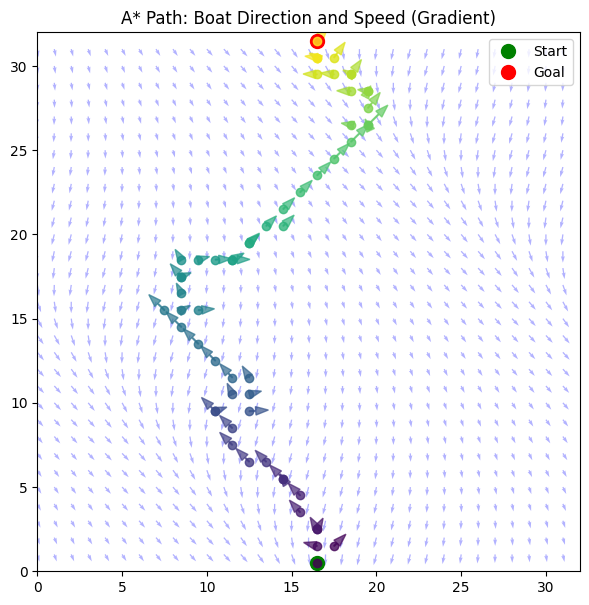

In [ ]:
def plot_a_star_arrows(frame, path, observation):
    """
    Plot the A* path as arrows showing direction and speed at each step,
    with intermediary positions colored in a gradient.
    """
    import matplotlib.cm as cm

    grid_size = env.grid_size
    wind_field_flat = observation[6:]
    wind_grid = wind_field_flat.reshape(grid_size[0], grid_size[1], 2)
    X, Y = np.meshgrid(np.arange(grid_size[0]), np.arange(grid_size[1]))
    U = wind_grid[:, :, 0].T
    V = wind_grid[:, :, 1].T

    fig, ax = plt.subplots(figsize=(7, 7))
    ax.set_xlim(0, grid_size[0])
    ax.set_ylim(0, grid_size[1])
    ax.set_title("A* Path: Boat Direction and Speed (Gradient)")

    ax.quiver(X, Y, U, V, color='blue', alpha=0.3)
    start = path[0]['pos']
    goal = path[-1]['pos']
    ax.plot(start[0]+0.5, start[1]+0.5, 'go', markersize=10, label="Start")
    ax.plot(goal[0]+0.5, goal[1]+0.5, 'ro', markersize=10, label="Goal")

    # Gradient colors for intermediary positions
    n = len(path)
    cmap = cm.get_cmap('viridis')
    for i, step in enumerate(path):
        pos = np.asarray(step['pos'])
        velocity = np.asarray(step['velocity'])
        color = cmap(i / (n-1)) if n > 1 else 'black'
        # Draw intermediary position
        ax.plot(pos[0]+0.5, pos[1]+0.5, marker='o', color=color, markersize=6, alpha=0.8)
        # Draw velocity arrow if nonzero
        if np.linalg.norm(velocity) > 1e-3:
            ax.arrow(
                pos[0]+0.5, pos[1]+0.5,
                velocity[0], velocity[1],
                color=color, width=0.05, head_width=0.5, length_includes_head=True, alpha=0.7
            )

    ax.legend()
    plt.show()

# Usage:
frame= env.render()
if path:
    plot_a_star_arrows(frame, path, observation)
else:
    print("No path found!")

In [ ]:
from tqdm import tqdm 
import matplotlib.cm as cm

action_map = {
    (0,1): 0,
    (1,1): 1,
    (1,0): 2,
    (1,-1): 3,
    (0,-1): 4,
    (-1,-1): 5,
    (-1,0): 6,
    (-1,1): 7,
    (0,0): 8
}

def plot_greedy_a_star_evolution(env, steps=5, plot_stride=1):
    obs, info = env.reset(seed=42)
    frames_obs = []
    paths_per_frame = []
    positions = [obs[:2].copy()]
    for step in tqdm(range(steps)):
        print(f"Step {step}, position: {obs[:2]}")
        frames_obs.append(obs.copy())
        path = sailing_a_star_env_action(env, obs[:2], env.goal_position)
        print(f"Path length: {len(path)}, first 5 steps: {path[1:2]}")
        paths_per_frame.append(path)
        direction_of_next_pos = path[1]['direction']
        action = action_map[tuple(direction_of_next_pos)]
        obs, reward, terminated, truncated, info = env.step(action)
        positions.append(obs[:2].copy())
        if terminated:
            break
    # Display only every plot_stride-th frame with wind quiver and path arrows
    indices_to_plot = list(range(0, len(frames_obs), plot_stride))
    fig, axes = plt.subplots(1, len(indices_to_plot), figsize=(4*len(indices_to_plot), 6))
    if len(indices_to_plot) == 1:
        axes = [axes]
    for ax, i in zip(axes, indices_to_plot):
        observation = frames_obs[i]
        grid_size = env.grid_size
        wind_field_flat = observation[6:]
        wind_grid = wind_field_flat.reshape(grid_size[0], grid_size[1], 2)
        X, Y = np.meshgrid(np.arange(grid_size[0]), np.arange(grid_size[1]))
        U = wind_grid[:, :, 0].T
        V = wind_grid[:, :, 1].T
        ax.quiver(X, Y, U, V, color='blue', alpha=0.3)
        ax.set_xlim(0, grid_size[0])
        ax.set_ylim(0, grid_size[1])
        ax.set_title(f"Step {i}")
        ax.axis('off')
        # Overlay A* path arrows
        if paths_per_frame[i]:
            path = paths_per_frame[i]
            n = len(path)
            cmap = cm.get_cmap('viridis')
            for j, step in enumerate(path):
                pos = np.asarray(step['pos'])
                velocity = np.asarray(step['velocity'])
                color = cmap(j / (n-1)) if n > 1 else 'black'
                ax.plot(pos[0]+0.5, pos[1]+0.5, marker='o', color=color, markersize=6, alpha=0.8)
                if np.linalg.norm(velocity) > 1e-3:
                    ax.arrow(
                        pos[0]+0.5, pos[1]+0.5,
                        velocity[0], velocity[1],
                        color=color, width=0.05, head_width=0.5, length_includes_head=True, alpha=0.7
                    )
    plt.tight_layout()
    plt.show()

# Usage:
plot_greedy_a_star_evolution(env, steps=50, plot_stride=5)

  0%|          | 0/50 [00:00<?, ?it/s]

Step 0, position: [16.  0.]


  2%|▏         | 1/50 [00:11<09:08, 11.20s/it]

Path length: 48, first 5 steps: [{'pos': (np.int32(16), np.int32(1)), 'velocity': array([0.       , 1.1571714], dtype=float32), 'direction': array([0., 1.], dtype=float32), 'wind': array([-0.9926938 ,  0.12066047], dtype=float32), 'efficiency': 1.0}]
Step 1, position: [16.  1.]


  2%|▏         | 1/50 [00:24<20:23, 24.96s/it]


KeyboardInterrupt: 